In [7]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from scipy import stats
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve,roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['gender_submission.csv', 'test.csv', 'train.csv']


In [8]:
import warnings
warnings.filterwarnings('ignore')

In [9]:
train_df = pd.read_csv('../input/train.csv', index_col=0)
test_df = pd.read_csv('../input/test.csv', index_col=0)
gender_sub = pd.read_csv('../input/gender_submission.csv')
combined_df = pd.concat([train_df, test_df])

In [10]:
train_df.info(), test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Name        891 non-null object
Sex         891 non-null object
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Ticket      891 non-null object
Fare        891 non-null float64
Cabin       204 non-null object
Embarked    889 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 10 columns):
Pclass      418 non-null int64
Name        418 non-null object
Sex         418 non-null object
Age         332 non-null float64
SibSp       418 non-null int64
Parch       418 non-null int64
Ticket      418 non-null object
Fare        417 non-null float64
Cabin       91 non-null object
Embarked    418 non-null object
dtypes: float64(2), int64(3), object(5)
memory usage: 35

(None, None)

There are few nulls in Embarked in both data set, quite a lot of empty values in Cabin feature and some in Age.

In [11]:
train_df.Cabin.isnull().sum()/len(train_df), test_df.Cabin.isnull().sum()/len(test_df)

(0.7710437710437711, 0.7822966507177034)

Between 77% and 78% is the percentage of nulls for Cabin in our datasets. That high percentage of empty values means no valuable insight could be extracted from this features.

In [12]:
combined_df['Age'].fillna(combined_df['Age'].mode().values[0], inplace=True)
combined_df['Embarked'].fillna(combined_df.Embarked.mode().values[0], inplace=True)
combined_df['Fare'].fillna(combined_df.Fare.median(), inplace=True)
combined_df.drop(columns = 'Cabin', inplace=True)

In [13]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 1 to 1309
Data columns (total 10 columns):
Age         1309 non-null float64
Embarked    1309 non-null object
Fare        1309 non-null float64
Name        1309 non-null object
Parch       1309 non-null int64
Pclass      1309 non-null int64
Sex         1309 non-null object
SibSp       1309 non-null int64
Survived    891 non-null float64
Ticket      1309 non-null object
dtypes: float64(3), int64(3), object(4)
memory usage: 112.5+ KB


In [14]:
feats = test_df.columns
train_df = combined_df[~combined_df.Survived.isnull()]
test_df = combined_df[combined_df.Survived.isnull()].drop(columns='Survived')
data_sets = [train_df, test_df]

In [15]:
train_df.info()
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 10 columns):
Age         891 non-null float64
Embarked    891 non-null object
Fare        891 non-null float64
Name        891 non-null object
Parch       891 non-null int64
Pclass      891 non-null int64
Sex         891 non-null object
SibSp       891 non-null int64
Survived    891 non-null float64
Ticket      891 non-null object
dtypes: float64(3), int64(3), object(4)
memory usage: 76.6+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 9 columns):
Age         418 non-null float64
Embarked    418 non-null object
Fare        418 non-null float64
Name        418 non-null object
Parch       418 non-null int64
Pclass      418 non-null int64
Sex         418 non-null object
SibSp       418 non-null int64
Ticket      418 non-null object
dtypes: float64(2), int64(3), object(4)
memory usage: 32.7+ KB


# Data visualization

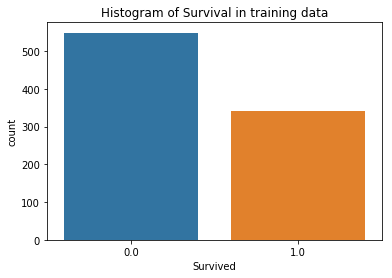

In [16]:
sns.countplot(train_df.Survived);
plt.title("Histogram of Survival in training data");

In [17]:
train_df.Survived.value_counts()/len(train_df)*100

0.0    61.616162
1.0    38.383838
Name: Survived, dtype: float64

61.6% of data has been classified as 0 - 'Not Survived' and 38.4 as 1 - 'Survived'. The split is reasonable there should be no issues related to imbalanced data for classifier.

In [18]:
train_df.dtypes

Age         float64
Embarked     object
Fare        float64
Name         object
Parch         int64
Pclass        int64
Sex          object
SibSp         int64
Survived    float64
Ticket       object
dtype: object

If we add SibSp & Parch together the results is number of family member onborad. Sounds like a good new feature.

In [19]:
feats = train_df.columns.tolist()
len(train_df.Ticket.unique())

681

Feature ticket has a lot of unique values, not uniques are probably a result of one ticket for couples or families/people starting jorney from the same port & same class etc...
I don't have knowledge that this feature contains any hidden information at this point and decide to exclude it from analysis. PassengerId is unique.
Feature name is also unique as a whole but it is possible to extract some valuable information from it.

In [20]:
titles = ['Mr', 'Mrs', 'Miss', 'Master']

In [21]:
def assign_titles(data):
    temp_titles_df = pd.DataFrame(index = data.index)
    temp_titles_df['Title1'] = data['Name'].apply(lambda x: titles[0] if titles[0] in x else None)
    temp_titles_df['Title2'] = data['Name'].apply(lambda x: titles[1] if titles[1] in x else None)
    temp_titles_df['Title3'] = data['Name'].apply(lambda x: titles[2] if titles[2] in x else None)
    temp_titles_df['Title4'] = data['Name'].apply(lambda x: titles[3] if titles[3] in x else None)
    
    def _return_corect_col(row):
        value = "Other"
        if row['Title1']:
            value = row['Title1']
        if row['Title2']:
            value = row['Title2']
        if row['Title3']:
            value = row['Title3']
        if row['Title4']:
            value = row['Title4']
        return value
    
    temp_titles_df['Title'] = temp_titles_df.apply(lambda x : _return_corect_col(x), axis=1)
    
    return pd.merge(data, temp_titles_df[['Title']], left_index=True, right_index=True)['Title']


In [22]:
for data in data_sets:
    data['Title'] = assign_titles(data) # engineering Title from feature Name
    data['FamilySize'] = data['SibSp'] + data['Parch'] # new feature as a combination of two others

In [23]:
data_sets[0].head()

,Age,Embarked,Fare,Name,Parch,Pclass,Sex,SibSp,Survived,Ticket,Title,FamilySize
PassengerId,,,,,,,,,,,,
1,22.0,S,7.2500,"Braund, Mr. Owen Harris",0,3,male,1,0.0,A/5 21171,Mr,1
2,38.0,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,1,female,1,1.0,PC 17599,Mrs,1
3,26.0,S,7.9250,"Heikkinen, Miss. Laina",0,3,female,0,1.0,STON/O2. 3101282,Miss,0
4,35.0,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,1,female,1,1.0,113803,Mrs,1
5,35.0,S,8.0500,"Allen, Mr. William Henry",0,3,male,0,0.0,373450,Mr,0


Now since we are done with feature engineering I can drop few features:

In [24]:
feats_to_drop = ['Ticket', 'Name']
for data in data_sets:
    data.drop(columns=feats_to_drop, inplace=True)

In [25]:
cat_feats = train_df.dtypes[train_df.dtypes == 'object'].index.values.tolist()
num_feats = train_df.dtypes[train_df.dtypes != 'object'].index.values.tolist()
cat_feats, num_feats

(['Embarked', 'Sex', 'Title'],
 ['Age', 'Fare', 'Parch', 'Pclass', 'SibSp', 'Survived', 'FamilySize'])

## Visualizing continous features

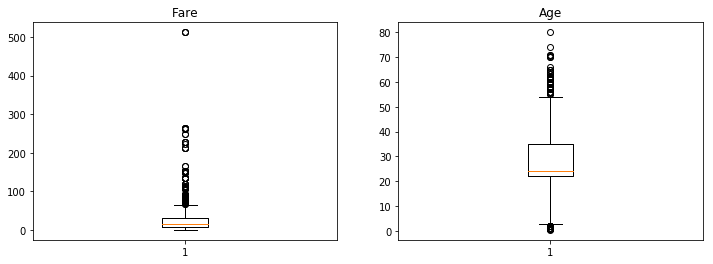

In [26]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.title('Fare')
plt.boxplot(train_df.Fare);

plt.subplot(1,2,2)
plt.title('Age')
plt.boxplot(train_df.Age);

In [27]:
print ("Fare median: {}, Fare mean: {} \nAge median: {}, Age mean: {}".format(
    np.median(train_df.Fare), np.mean(train_df.Fare), np.median(train_df.Age), np.mean(train_df.Age)))

Fare median: 14.4542, Fare mean: 32.2042079685746 
Age median: 24.0, Age mean: 28.566969696969696


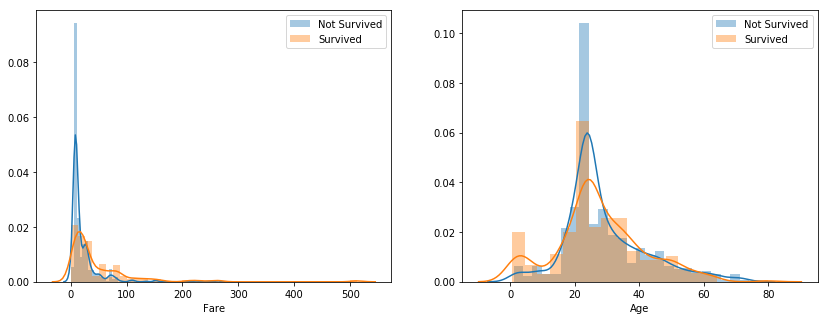

In [28]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)

sns.distplot(train_df[train_df.Survived == 0]['Fare'], label='Not Survived');
sns.distplot(train_df[train_df.Survived == 1]['Fare'], label='Survived');
plt.legend();

plt.subplot(1,2,2)
sns.distplot(train_df[train_df.Survived == 0]['Age'], label='Not Survived');
sns.distplot(train_df[train_df.Survived == 1]['Age'], label='Survived');
plt.legend();

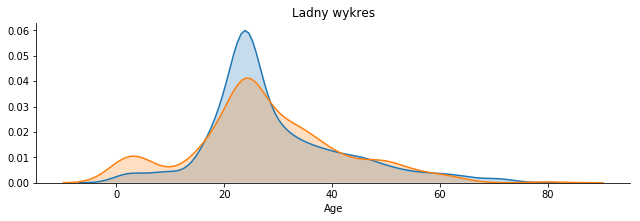

In [29]:
a = sns.FacetGrid(train_df, hue = 'Survived', aspect=3)
a.map(sns.kdeplot, 'Age', shade= True );
plt.title("Ladny wykres");

The distribution of Fare shows that in the range of lowest Fare <0, 40?) there has been more 'Not Survived' examples, for Fares higher than ~50 there is visible margin -> more examples marked as 'Survived'.
Looking at the Age distrubition, one can see that for lowest values of Age <0,10?) there is more 'Surived' examples, same is visible at range around 30-40.

## Categorical features

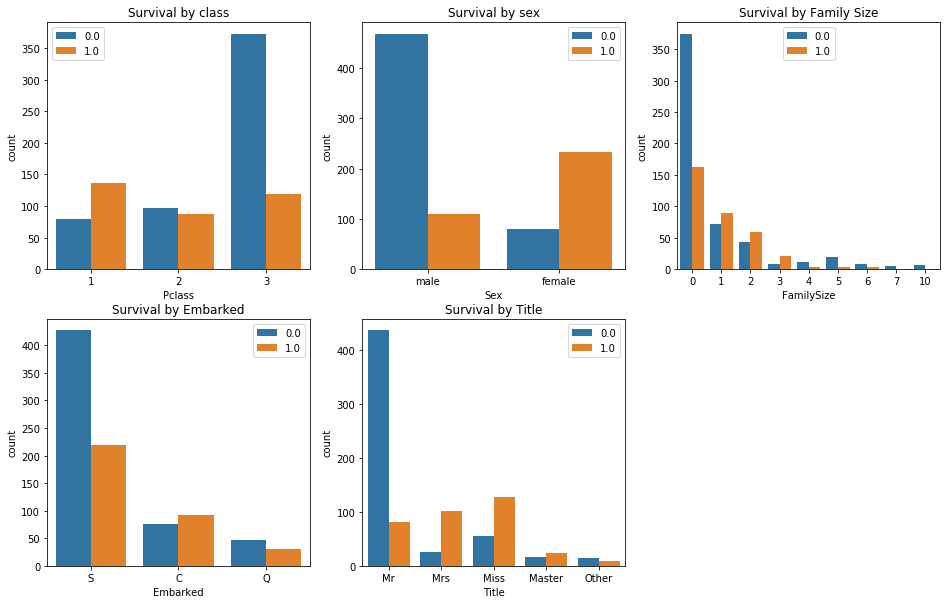

In [30]:
train_df = data_sets[0]

plt.figure(figsize=(16,10))

plt.subplot(2,3,1)
plt.title("Survival by class");
sns.countplot(x='Pclass', hue='Survived', data=train_df);
plt.legend();

plt.subplot(2,3,2)
plt.title("Survival by sex");
sns.countplot(x='Sex', hue='Survived', data=train_df);
plt.legend();

plt.subplot(2,3,3)
plt.title("Survival by Family Size");
sns.countplot(x='FamilySize', hue='Survived', data=train_df);
plt.legend();

plt.subplot(2,3,4)
plt.title("Survival by Embarked");
sns.countplot(x='Embarked', hue='Survived', data=train_df);
plt.legend();

plt.subplot(2,3,5)
plt.title("Survival by Title");
sns.countplot(x='Title', hue='Survived', data=train_df);
plt.legend();

Analyzing graphs from left to right.
Pclass has significant impact on dependent variable. The amount of people who survived is increasing with increasing socio-economic status.
Between male and females, most of male has not survived whereas most of females has survived.
People who has from 1-3 family members onboard tend to survive more likely.
More people from those embarked in Cherbourg has survived.
Looking at Title we can only confirm previous findings that more womens survived than mans.

In [31]:
# combined_df['Sex_cat'] = pd.factorize(combined_df.Sex)[0]
# combined_df['Embarked_cat'] = pd.factorize(combined_df.Embarked)[0]

In [32]:
train_df.head()

,Age,Embarked,Fare,Parch,Pclass,Sex,SibSp,Survived,Title,FamilySize
PassengerId,,,,,,,,,,
1,22.0,S,7.2500,0,3,male,1,0.0,Mr,1
2,38.0,C,71.2833,0,1,female,1,1.0,Mrs,1
3,26.0,S,7.9250,0,3,female,0,1.0,Miss,0
4,35.0,S,53.1000,0,1,female,1,1.0,Mrs,1
5,35.0,S,8.0500,0,3,male,0,0.0,Mr,0


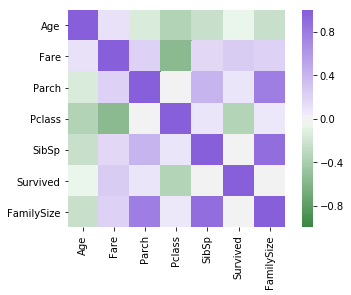

In [33]:
corr_df = train_df.corr()
sns.heatmap(corr_df, vmin=-1, vmax=1, center=0,
    cmap= sns.diverging_palette(130, 275, n=200),
    square=True);

FamilySize is highly correlated with SibSp and Parch - it is not a suprise because it has been built as a combination of them. There is a decent correlation between Pclass and Fare, Survived and Fare (seen on plots), Survived and Pclass (also seen on plots) and few others.

In [34]:
corr_df = train_df.corr().abs().unstack().sort_values(ascending=False).reset_index().rename(
    columns={'level_0':'Feature 1', 'level_1':'Feature 2', 0:'Corr coef'})
corr_df.drop(corr_df[corr_df['Corr coef']==1].index, inplace=True)
corr_df = corr_df.iloc[1::2]
corr_df.reset_index(drop=True).iloc[range(0,10),:]

,Feature 1,Feature 2,Corr coef
0,SibSp,FamilySize,0.890712
1,Parch,FamilySize,0.783111
2,Pclass,Fare,0.549500
3,SibSp,Parch,0.414838
4,Pclass,Age,0.356187
5,Survived,Pclass,0.338481
6,Fare,Survived,0.257307
7,Age,FamilySize,0.236339
8,Age,SibSp,0.232411
9,Fare,FamilySize,0.217138


#### Converting categorical variables to numerical

In [35]:
for i in range(0, len(data_sets)):
    data_sets[i] = pd.get_dummies(data_sets[i])

#### Preparing for modelling

In [36]:
train_df, test_df = data_sets
X_train, X_val, Y_train, Y_val = train_test_split(train_df.drop(columns='Survived'), train_df.Survived)
X_test = data_sets[1]

## Modelling

In [37]:
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train, Y_train)
y_train_pred = rf_clf.predict(X_train)
y_val_pred = rf_clf.predict(X_val)
y_val_pred_prob = rf_clf.predict_proba(X_val)[:,1]
metrics.accuracy_score(Y_train, y_train_pred), metrics.accuracy_score(Y_val, y_val_pred)

(0.9655688622754491, 0.8026905829596412)

Accuracy score says how many did the classifier labeled correctly out of all samples.
96% accuracy score on training test and 83% on validation test.
Let's see confussion matrix.

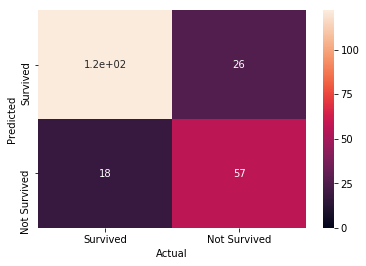

In [38]:
conf_mat = confusion_matrix(y_val_pred, Y_val)
sns.heatmap(pd.DataFrame(conf_mat, index=['Survived', 'Not Survived'], columns = ['Survived', 'Not Survived']), annot=True, vmin=0);
plt.xlabel('Actual');
plt.ylabel('Predicted');

In [39]:
tp, fn, fp, tn = confusion_matrix(y_val_pred, Y_val).ravel()
tp, fn, fp, tn

(122, 26, 18, 57)

In [40]:
metrics.precision_recall_fscore_support(Y_val, y_val_pred)

(array([0.82432432, 0.76      ]),
 array([0.87142857, 0.68674699]),
 array([0.84722222, 0.72151899]),
 array([140,  83], dtype=int64))

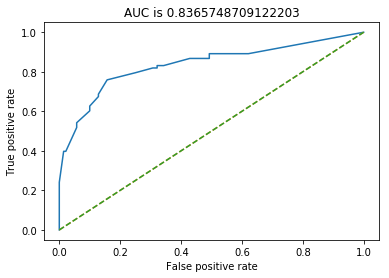

In [41]:
fpr, tpr, thresholds = roc_curve(Y_val, y_val_pred_prob)
plt.plot(fpr, tpr);
plt.plot([[0,0], [1,1]], linestyle='dashed');
plt.ylabel('True positive rate');
plt.xlabel('False positive rate');
plt.title('AUC is {}'.format(roc_auc_score(Y_val, y_val_pred_prob)));

#### Hyperparameters optimization with GridSearchCV

In [42]:
params = {'n_estimators' : [5, 10, 20, 50, 100, 200], 'criterion' : ['gini', 'entropy'],
          'max_depth': [2, 4, 6, 8, 10, None], 'random_state':[0]}

In [43]:
rf = RandomForestClassifier()
clf = GridSearchCV(rf, params, cv=3)
clf.fit(X_train, Y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

In [44]:
clf.best_params_

{'criterion': 'entropy', 'max_depth': 6, 'n_estimators': 20, 'random_state': 0}

In [45]:
rf_clf2 = RandomForestClassifier(criterion='entropy', max_depth=8, n_estimators= 100, random_state= 0)
rf_clf2.fit(X_train, Y_train)
y_train_pred = rf_clf2.predict(X_train)
y_val_pred = rf_clf2.predict(X_val)
y_val_pred_prob = rf_clf2.predict_proba(X_val)[:,1]
metrics.accuracy_score(Y_train, y_train_pred), metrics.accuracy_score(Y_val, y_val_pred)

(0.8997005988023952, 0.8116591928251121)

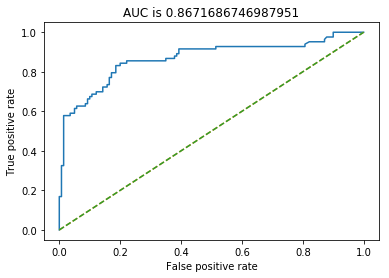

In [46]:
fpr, tpr, thresholds = roc_curve(Y_val, y_val_pred_prob)
plt.plot(fpr, tpr);
plt.plot([[0,0], [1,1]], linestyle='dashed');
plt.ylabel('True positive rate');
plt.xlabel('False positive rate');
plt.title('AUC is {}'.format(roc_auc_score(Y_val, y_val_pred_prob)));

#### Since we have the best hyperparameters for Random Forest we can fit on whole training data and make a prediciton on test df

In [47]:
rf_clf3 = RandomForestClassifier(criterion='entropy', max_depth=8, n_estimators= 100, random_state= 0)

In [53]:
rf_clf3.fit(train_df.drop(columns='Survived'), train_df.Survived)
y_pred_test = rf_clf3.predict(X_test).astypetype(int)

In [55]:
submission = pd.DataFrame(y_pred_test, index=X_test.index, columns=['Survived'])
submission.head()

,Survived
PassengerId,
892,0
893,0
894,0
895,0
896,1


In [56]:
submission.to_csv('titanic_submission.csv')